# A few simple corpus-driven approaches to narrative analysis and generation

By [Allison Parrish](http://www.decontextualize.com/)

This notebook is a fast introduction to a few techniques for working with narrative corpora. By "narrative corpora," I mean pre-existing bodies of text that mostly contain the texts of narratives. In particular, we're going to use Mark Riedl's [WikiPlots corpus](https://github.com/markriedl/WikiPlots), which has the titles and plot summaries of more than one hundred thousand movies, books, television shows and other media from Wikipedia.

The notebook takes you through using [spaCy](http://spacy.io) to extract words, noun chunks, parts of speech and entities from the text and then sew them back together with [Tracery](http://tracery.io). It then shows how to use [Markovify](https://github.com/jsvine/markovify) to create new narratives from existing narrative text, and how to prepare the narratives for use as a training corpus for a large pre-trained language model like GPT-2.

The code is written in Python, but you don't really need to know Python in order to use the notebook. Everything's pre-written for you, so you can just execute the cells, making small changes to the code as needed. Even if the notebook itself doesn't end up being useful to you, hopefully it spurs a few ideas that you can take with you into your practice as a storyteller and/or programmer.

If you're running this code on Binder, you should be good to go. Just keep on executing the cells below. If you're running this notebook on Google Colab, you'll need to run the following cells to install the necessary libraries and download the data:

In [ ]:
!pip install markovify
!pip install tracery
!pip install spacy==2.3.2
!python -m spacy download en_core_web_sm
!curl -L -O https://github.com/aparrish/corpus-driven-narrative-generation/raw/master/romcom_plot_sentences.tsv

## Loading the corpus

The first step is to get the narrative corpus into the program. Because WikiPlots is so big, we're actually going to be working with a smaller subset: only the plot summaries for romantic comedy movies. The subcorpus was made using [this notebook on creating a subcorpus of WikiPlots](https://github.com/aparrish/corpus-driven-narrative-generation/blob/master/creating-a-wikiplots-subcorpus.ipynb), which you can consult if you want to make your own with a different subset of WikiPlots.

The corpus we're working with takes the form of a TSV file ("tab separated values"), with each line containing the title of the movie, a number indicating where in the plot summary the sentence for this line occurs, the total number of sentences in the summary, and the actual text of the sentence. The following cell loads the data into a list of dictionaries:

In [7]:
sentences = []
for line in open("romcom_plot_sentences.tsv"):
    line = line.strip()
    items = line.split("\t")
    sentences.append(
        {'title': items[0],
         'index': int(items[1]),
         'total': int(items[2]),
         'text': items[3]})

Just to make sure it worked, we'll print out a random sentence:

In [2]:
import random
random.choice(sentences)

{'title': 'Bruce Almighty',
 'index': 20,
 'total': 32,
 'text': 'Bruce then begins to solve his problems in life practically, such as helping a man whose car has broken down, training his dog normally, and allowing Evan to have his job back.'}

Note: You can make your own corpus that works with the code in this notebook by exporting your data in TSV format with one line per sentence, with columns for the following:

* `title`: the title of the work that the sentence comes from
* `index`: the index of the sentence in the work
* `total`: the total number of sentences in the work
* `text`: the text of the sentence

## Natural language processing

To get an idea of what's happening in the text of the plots, we can do a bit of Natural Language Processing. I cover just the bare essentials in this notebook. [Here's a more in-depth tutorial that I wrote](https://github.com/aparrish/rwet/blob/master/nlp-concepts-with-spacy.ipynb).

Most natural language processing is done with the aid of third-party libraries. We're going to use one called spaCy. To use spaCy, you first need to install it (i.e., download the code and put it in a place where Python can find it) and download the language model. (The language model contains statistical information about a particular language that makes it possible for spaCy to do things like parse sentences into their constituent parts.)

Run the following cell to load spaCy's model:

In [3]:
import spacy
nlp = spacy.load('en_core_web_sm')

(This could also take a while–the model is potentially very large and your computer needs to load it from your hard drive and into memory. When you see a `[*]` next to a cell, that means that your computer is still working on executing the code in the cell.)

Right off the bat, the spaCy library gives us access to a number of interesting units of text:

* All of the sentences (`doc.sents`)
* All of the words (`doc`)
* All of the "named entities," like names of places, people, #brands, etc. (`doc.ents`)
* All of the "noun chunks," i.e., nouns in the text plus surrounding matter like adjectives and articles

The cell below, we extract these into variables so we can play around with them a little bit. (Parsing sentences is hungry work and the following cell will take a while to execute.)

In [8]:
words = []
noun_chunks = []
entities = []
#save out the plot sentences for visualization
plot = []

# only use 1000 sentences sampled at random by default; comment out this `for...`
# uncomment the `for...` beneath to use every sentence in the corpus.
for i, sent in enumerate(random.sample(sentences, 1000)):
#for i, sent in enumerate(sentences):
    if i % 100 == 0:
        print(i, len(sentences))
    doc = nlp(sent['text'])
    plot.append(doc)
    words.extend([w for w in list(doc) if w.is_alpha])
    noun_chunks.extend(list(doc.noun_chunks))
    entities.extend(list(doc.ents))

0 28785
100 28785
200 28785
300 28785
400 28785
500 28785
600 28785
700 28785
800 28785
900 28785


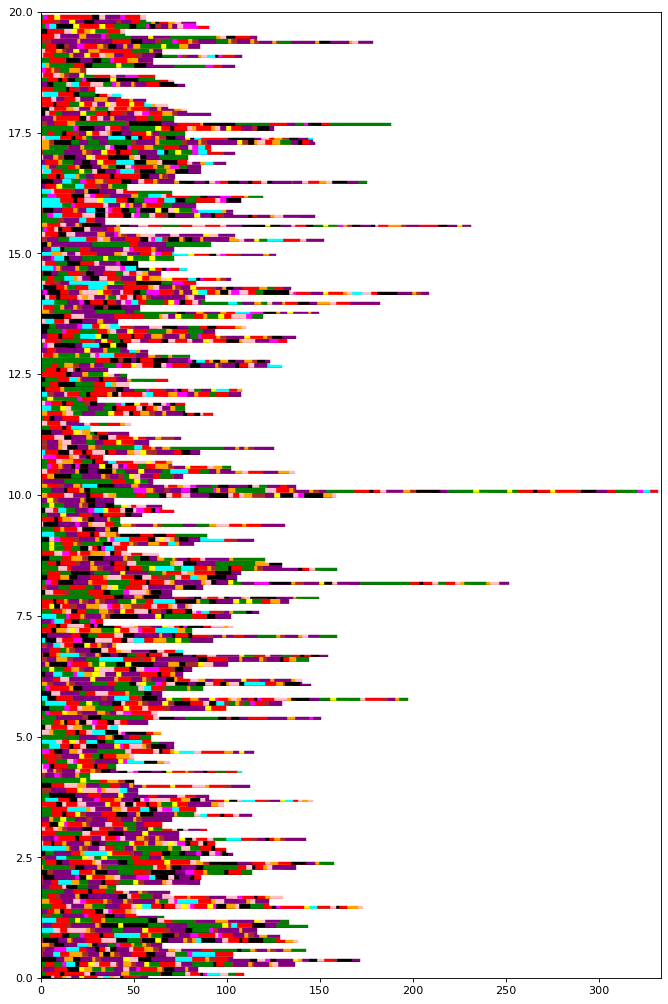

In [9]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

max_x = 0
num_sentences = 200

#define Matplotlib figure and axis
fig, ax = plt.subplots(figsize=(10, 16), dpi=80)

for p in range(0, num_sentences):
    parsed = []
    parsed.extend([w for w in list(plot[p]) if w.is_alpha])
    w_beg = 0
    w_end = 0
    
    for i in range(0, len(parsed)):
        #print(parsed[i].pos_)

        w_end = w_end + len(parsed[i])
        
        #update y axis max value
        if(w_end > max_x):
            max_x = w_end

        #assign each sentence word a color by type of word
        color = 'black'
        if(parsed[i].pos_ == "PRON"):
            color = 'pink'
        elif(parsed[i].pos_ == "VERB"):
            color = 'red'
        elif(parsed[i].pos_ == "CCONJ"):
            color = 'yellow'
        elif(parsed[i].pos_ == "PROPN"):
            color = 'green'
        elif(parsed[i].pos_ == "CCONJ"):
            color = 'blue'
        elif(parsed[i].pos_ == "AUX"):
            color = 'magenta'
        elif(parsed[i].pos_ == "ADV"):
            color = 'cyan'
        elif(parsed[i].pos_ == "DET"):
            color = 'brown'
        elif(parsed[i].pos_ == "NOUN"):
            color = 'purple'
        elif(parsed[i].pos_ == "ADP"):
            color = 'orange'
        #add rectangle to plot
        ax.add_patch(Rectangle((w_beg, (p*.1)), w_end, (p*.1)+.1, edgecolor = color,
                 facecolor = color,
                 fill=True,
                 lw=5))
        w_beg = w_end

    ax.add_patch(Rectangle((w_beg, (p*.1)-.04), 500, (p*.1)+.1, edgecolor = 'white',
             facecolor = 'white',
             fill=True,
             lw=5))

ax.add_patch(Rectangle((0, (p*.1)+.1), 500, 20, edgecolor = 'white',
         facecolor = 'white',
         fill=True,
         lw=5))

plt.xlim([0, max_x])
plt.ylim([0, num_sentences*.1])

#display plot
plt.show()

fig.savefig('vis.png', bbox_inches='tight', dpi=300)

In [10]:
first = []
second = []
count = []

for p in range(0, num_sentences):
    parsed = []
    parsed.extend([w for w in list(plot[p]) if w.is_alpha])
    
    #print(parsed[0].pos_, parsed[1].pos_)
    
    found = False
    for n in range(len(count)):
        if (first[n]==parsed[0].pos_ and second[n]==parsed[1].pos_):
            count[n] = count[n] + 1
            found = True
    
    if (found==False):
        first.append(parsed[0].pos_)
        second.append(parsed[1].pos_)
        count.append(1)

#sort based on counts
count, first, second = zip(*sorted(zip(count, first, second)))

for c in range(1, len(count)):
    print(first[len(count)-c], second[len(count)-c], count[len(count)-c])
            

PROPN VERB 27
PRON VERB 20
DET NOUN 13
ADP DET 13
SCONJ PRON 11
PROPN AUX 10
PROPN PROPN 7
NOUN VERB 7
ADP VERB 6
SCONJ PROPN 5
PROPN CCONJ 5
PRON ADV 5
DET ADJ 5
PRON AUX 4
ADV PROPN 4
VERB PRON 3
SCONJ VERB 3
PROPN ADV 3
ADV PRON 3
ADV ADP 3
ADP PROPN 3
NUM NOUN 2
NOUN AUX 2
NOUN ADP 2
DET PROPN 2
ADV VERB 2
ADV SCONJ 2
ADV ADV 2
ADJ PROPN 2
ADJ NOUN 2
VERB PART 1
VERB DET 1
VERB ADP 1
SCONJ DET 1
SCONJ ADP 1
PROPN NOUN 1
PROPN DET 1
PROPN ADJ 1
PRON NOUN 1
PRON ADP 1
PRON ADJ 1
NOUN NOUN 1
NOUN CCONJ 1
DET NUM 1
ADV DET 1
ADV AUX 1
ADV ADJ 1
ADP PRON 1
ADJ VERB 1
ADJ PRON 1
ADJ PART 1


In [11]:
global sentences
sentences = []

import csv

firstpath = "aaryan2.txt"
    
for line in open(firstpath,encoding='utf-8'):
    line = line.strip()
    csv.reader(firstpath, delimiter = ".")
    items = line.split("#")
    sentences.append(
        {'title': items[0], 
         'text': items[1],
         'classification': items[5],
        })


In [12]:
#take the first story
text = sentences[0]['text'].split(".")
print(len(text))

227


In [13]:
import math

#fill lists of first and second word combinations and keep counts
def evaluate_text(start, end):
    first = []
    second = []
    count = []
    for p in range(start, end):
        parsed = []
        doc = nlp(text[p])
        parsed.extend([w for w in list(doc) if w.is_alpha])

        found = False
        if(len(parsed) > 1): 
            for n in range(len(count)):
                if (first[n]==parsed[0].pos_ and second[n]==parsed[1].pos_):
                    count[n] = count[n] + 1
                    found = True

            if (found==False):
                first.append(parsed[0].pos_)
                second.append(parsed[1].pos_)
                count.append(1)

    #sort based on counts
    count, first, second = zip(*sorted(zip(count, first, second)))

    for c in range(1,8):
        print(first[len(count)-c], second[len(count)-c], count[len(count)-c])

#evaluate the first third of the story:
evaluate_text(0, math.floor(len(text)/3))

print('--------')

#evaluate the second third of the story:
evaluate_text(math.floor(len(text)/3), math.floor(2*len(text)/3))

print('--------')

#evaluate the second third of the story:
evaluate_text(math.floor(2*len(text)/3), len(text))
            

DET NOUN 16
PRON AUX 9
PRON VERB 7
ADP DET 5
DET ADJ 3
ADP NOUN 3
SCONJ DET 2
--------
PRON AUX 18
PRON VERB 13
DET NOUN 6
ADP DET 6
SCONJ PRON 4
ADV PRON 3
PRON NOUN 2
--------
PRON VERB 17
DET NOUN 12
PRON AUX 10
SCONJ PRON 6
PRON ADV 5
PRON PRON 3
PRON NOUN 3


In [ ]:
# Provide ability to interact with the plot sentences visualization
# and capture the keyboard and mouse use of the user

from tkinter import *
from tkinter.filedialog import *
from PIL import Image, ImageTk
import numpy as np

# --- functions ---

w = 6 # brush size
a = 0 # index for active color
paints_list=[]
color_list = ["white", "black"]
v_index = 300;
canvas = "";
last_x = 0;
last_y = 0;

def change_color():
    global a
    a = (a + 1) % 2  
    
def savefile():
    # save the canvas out
    img.save("vis_canvas.png", lossless=True)
        
def on_click(event):
    global lastx, lasty
    lastx,  lasty =  event.x, event.y
    
    with open("UserRecord.txt", "a") as f:
        f.write('Cursor clicked at {0}'.format((lastx, lasty)) + "\n")

def on_release(event):
    global lastx, lasty
    lastx,  lasty =  event.x, event.y
    
    with open("UserRecord.txt", "a") as f:
        f.write('Cursor released at {0}'.format((lastx, lasty)) + "\n")
    
def draw(event):
    """
    drawing
    updating the coordinates of the cursor
    adding all the marks created to a list
    """
    global lastx, lasty, c1
    c1 = canvas.create_line((lastx, lasty, event.x, event.y), fill=color_list[a], width = w)
    paints_list.append(c1)
    lastx, lasty = event.x, event.y
    with open("UserRecord.txt", "a") as f:
        f.write('Cursor moved to {0}, brush_size = {1}, color = {2}'.format((lastx, lasty), w, color_list[a]) + "\n")
    
def scroll_image(event):
    """changes which plot line is being shown first"""
    global v_index
    global canvas

    if event.delta > 0:
    # if mouse scrolls up
        v_index = v_index + event.delta
    else:
    # if mouse scrolls down
        v_index = v_index + event.delta
        
    canvas.create_image(-120, -1*v_index, anchor='nw', image=image)

# --- main ---

# clear the user actions log
with open("UserRecord.txt", 'w+') as f:
    f.truncate(0)

app = Tk()
app.geometry("1200x640")
app.title("plot investigator")

canvas = Canvas(app, width=900, height=800, bg='white')
canvas.pack(anchor='nw', fill='both', expand=True)
canvas.grid(row=0, column=0)

canvas.bind(sequence="<Button-1>", func=on_click, add="+")
canvas.bind(sequence="<ButtonRelease>", func=on_release, add="+")
canvas.bind(sequence="<B1-Motion>", func=draw)
canvas.bind(sequence='<MouseWheel>',func=scroll_image)

image = Image.open('vis.png')
image = ImageTk.PhotoImage(image)

canvas.create_image(-120, -1*v_index, anchor='nw', image=image)

app.mainloop()

# save the image
#savefile()

In [6]:
# Just to make sure it worked, print out ten random words

for item in random.sample(words, 10):
    print(item.text)

then
changed
dating
love
the
fails
signs
return
marry
it


Ten random noun chunks:

In [7]:
for item in random.sample(noun_chunks, 10):
    print(item.text)

a seemingly-deserted island
Pride
charlatan mystics
a clean health record
Paige's medical school ambitions
Elizabeth
the editor
town
Stephanie
She


Ten random entities:

In [8]:
for item in random.sample(entities, 10):
    print(item.text)

Anne Marie
Mumbai
Grace
Laida
Isolde
Jane
Rod
Lacuna
Fraser
Vogue


### Grammatical roles

The parser included with spaCy can also give us information about the grammatical roles in the sentence. For example, the `.root.dep_` attribute of a noun chunk tells us whether that noun chunk is the subject of the sentence ("nsubj") or a direct object ("dobj") of the sentence. (See the "Universal Dependency Labels" of spaCy's [annotation specs](https://spacy.io/api/annotation) for more possible roles.) Using this information, we can make a list of sentence subjects and sentence objects:

In [10]:
subjects = [chunk for chunk in noun_chunks if chunk.root.dep_ == 'nsubj']
objects = [chunk for chunk in noun_chunks if chunk.root.dep_ == 'dobj']

In [11]:
random.sample(subjects, 10)

[he,
 Paige's father,
 This novel,
 you,
 a constrained life,
 Alexandra,
 Jack,
 the fantasy,
 he,
 her uncle]

In [12]:
random.sample(objects, 10)

[him,
 him,
 what,
 an old romance,
 his money,
 her,
 the tension,
 Mike's card,
 what,
 his pregnant girlfriend]

### Parts of speech

The spaCy parser allows us to check what part of speech a word belongs to. In the cell below, we create four different lists—`nouns`, `verbs`, `adjs` and `advs`—that contain only words of the specified parts of speech. Using the `.tag_` attribute, we can easily get only particular forms of verbs; in this case, I'm just getting verbs that are in the past tense. ([There's a full list of part of speech tags here](https://spacy.io/docs/usage/pos-tagging#pos-tagging-english).)

In [13]:
nouns = [w for w in words if w.pos_ == "NOUN"]
verbs = [w for w in words if w.pos_ == "VERB"]
past_tense_verbs = [w for w in words if w.tag_ == 'VBD']
adjs = [w for w in words if w.tag_ == "JJ"]
advs = [w for w in words if w.pos_ == "ADV"]

And now we can print out a random sample of any of these:

In [14]:
for item in random.sample(nouns, 12): # change "nouns" to "verbs" or "adjs" or "advs" to sample from those lists!
    print(item.text)

way
outlaw
notes
couple
dinner
cast
boyfriend
house
schemer
father
process
allergy


### Entity types

The parser in spaCy not only identifies "entities" but also assigns them to a particular type. [See a full list of entity types here.](https://spacy.io/docs/usage/entity-recognition#entity-types) Using this information, the following cell builds lists of the people, locations, and times mentioned in the text:

In [15]:
people = [e for e in entities if e.label_ == "PERSON"]
locations = [e for e in entities if e.label_ == "LOC"]
times = [e for e in entities if e.label_ == "TIME"]

And then you can print out a random sample:

In [16]:
for item in random.sample(times, 12): # change "times" to "people" or "locations" to sample those lists
    print(item.text.strip())

Later that evening
that night
one night
The next morning
one night
the night
the middle of the night
3 AM
the following morning
that evening
only a few hours
the night


### Finding the most common

We won't go too deep into text analysis in this tutorial, but it's useful to be able to do the most fundamental task in text analysis: finding the things that are most common. The code to do this task looks like the following, which gives us a way to look up how often any word occurs in the text:

In [17]:
from collections import Counter
word_count = Counter([w.text for w in words])

In [22]:
word_count['lost']

5

... and also tells us which words are most common:

In [23]:
word_count.most_common(12)

[('the', 965),
 ('to', 786),
 ('and', 696),
 ('a', 506),
 ('her', 359),
 ('of', 344),
 ('is', 330),
 ('his', 325),
 ('in', 286),
 ('he', 273),
 ('that', 258),
 ('with', 240)]

You can make a counter for any of the other lists we've worked with using the same syntax. Just make up a unique variable name on the left of the `=` sign and put the name of the list you want to count in the brackets to the right (replacing `words`). E.g., to find the most common people:

In [24]:
people_count = Counter([w.text for w in people])

In [25]:
people_count.most_common(12)

[('Mary', 14),
 ('Tom', 13),
 ('Sam', 11),
 ('Anna', 11),
 ('Peter', 11),
 ('Kate', 11),
 ('George', 10),
 ('Joe', 9),
 ('Adam', 9),
 ('Dick', 8),
 ('Ryan', 8),
 ('Andy', 8)]

The most common past-tense verbs:

In [26]:
vbd_count = Counter([w.text for w in past_tense_verbs])

In [27]:
vbd_count.most_common(12)

[('had', 36),
 ('was', 30),
 ('were', 9),
 ('did', 8),
 ('married', 4),
 ('gave', 4),
 ('happened', 3),
 ('went', 3),
 ('ended', 3),
 ('broke', 3),
 ('died', 3),
 ('told', 3)]

### Writing to a file

The following cell defines a function for writing data from a `Counter` object to a file. The file is in "tab-separated values" format, which you can open using most spreadsheet programs. Execute it before you continue:

In [24]:
def save_counter_tsv(filename, counter, limit=1000):
    with open(filename, "w") as outfile:
        outfile.write("key\tvalue\n")
        for item, count in counter.most_common():
            outfile.write(item.strip() + "\t" + str(count) + "\n")    

Now, run the following cell. You'll end up with a file in the same directory as this notebook called `100_common_words.tsv` that has two columns, one for the words and one for their associated counts:

In [25]:
save_counter_tsv("100_common_words.tsv", word_count, 100)

Try opening this file in Excel or Google Docs or Numbers!

If you want to write the data from another `Counter` object to a file:

* Change the filename to whatever you want (though you should probably keep the `.tsv` extension)
* Replace `word_count` with the name of any of the `Counter` objects we've made in this sheet and use it in place of `word_count`
* Change the number to the number of rows you want to include in your spreadsheet.

### When do things happen in this text?

Here's another example. Using the `times` entities, we can make a spreadsheet of how often particular "times" (durations, times of day, etc.) are mentioned in the text.

In [26]:
time_counter = Counter([e.text.lower().strip() for e in times])
save_counter_tsv("time_count.tsv", time_counter, 100)

Do the same thing, but with people:

In [27]:
people_counter = Counter([e.text.lower() for e in people])
save_counter_tsv("people_count.tsv", people_counter, 100)

### Generating stories from a corpus and Tracery grammars

Once you've isolated entities and parts of speech, you can recombine them in interesting ways. One is to use a Tracery grammar to write sentences that include the isolated parts. Because the parts have been labelled using spaCy, you can be reasonbly sure that they'll fit into particular slots in the sentence. (I used a similar technique for my [Cheap Space Nine](https://twitter.com/cheapspacenine) bot.)

In [28]:
import tracery
from tracery.modifiers import base_english

In [29]:
rules = {
    "subject": [w.text for w in subjects],
    "object": [w.text for w in objects],
    "verb": [w.text for w in past_tense_verbs if w.text not in ('was', 'were', 'went')], # exclude common irregular verbs
    "adj": [w.text for w in adjs],
    "people": [w.text for w in people],
    "loc": [w.text for w in locations],
    "time": [w.text for w in times],
    "origin": "#scene#\n\n[charA:#subject#][charB:#subject#][prop:#object#]#sentences#",
    "scene": "SCENE: #loc#, #time.lowercase#",
    "sentences": [
        "#sentence#\n#sentence#",
        "#sentence#\n#sentence#\n#sentence#",
        "#sentence#\n#sentence#\n#sentence#\n#sentence#"
    ],
    "sentence": [
        "#charA.capitalize# #verb# #prop#.",
        "#charB.capitalize# #verb# #prop#.",
        "#prop.capitalize# became #adj#.",
        "#charA.capitalize# and #charB# greeted each other.",
        "'Did you hear about #object.lowercase#?' said #charA#.",
        "'#subject.capitalize# is #adj#,' said #charB#.",
        "#charA.capitalize# and #charB# #verb# #object#.",
        "#charA.capitalize# and #charB# looked at each other.",
        "#sentence#\n#sentence#"
    ]
}

In [30]:
grammar = tracery.Grammar(rules)
grammar.add_modifiers(base_english)

In [31]:
for i in range(3):
    print(grammar.flatten("#origin#"))
    print()

SCENE: Europe, one night

'Did you hear about him?' said he.
The whole day became private.
He and Dean Clinton looked at each other.
He and Dean Clinton had his grandmother.

SCENE: Kimberly, a night

Doris Attinger and them looked at each other.
Them became the principal.

SCENE: Earth, just a few hours

'Did you hear about sally?' said her.
'An infatuated Doris is special,' said Tony.
Her and Tony looked at each other.
Tony took a wager.



## Markov chain text generation

Another way to produce new narratives from existing narrative text is to find statistical patterns in the text itself and then make the computer create new text that follows those statistical patterns. Markov chain text generation has been a pastime of poets and programmers going back [all the way to 1983](https://www.jstor.org/stable/24969024), so it should be no surprise that there are many implementations of the idea in Python that you can download and install. The one we're going to use is [Markovify](https://github.com/jsvine/markovify), a Markov chain text generation library originally developed for BuzzFeed, apparently. Writing [code to implement a Markov chain generator](https://github.com/aparrish/rwet/blob/master/ngrams-and-markov-chains.ipynb) on your own is certainly possible, but Markovify comes with a lot of extra niceties that will make our lives easier.

To install Markovify on your computer, run the cell below. (You can skip this step if you're using this notebook in Binder.)

In [ ]:
!pip install markovify

You should consider upgrading via the 'pip install --upgrade pip' command.


And then run this cell to make the library available in your notebook:

In [32]:
import markovify

We need a list of strings to train the Markov generator. For now, let's just get all of the sentences from any movie in the corpus:

In [33]:
all_text = [item['text'] for item in sentences]

The code in the following cell creates a new text generator, using the text in the variable specified to build the Markov model, which is then assigned to the variable `all_text_gen`.

In [34]:
all_text_gen = markovify.Text(all_text)

You can then call the `.make_sentence()` method to generate a sentence from the model:

In [35]:
print(all_text_gen.make_sentence())

Izzy promises not to tell him it looks like the Bachelor TV show, restoring his fortunes in the children's home.


The `.make_short_sentence()` method allows you to specify a maximum length for the generated sentence:

In [36]:
print(all_text_gen.make_short_sentence(50))

He however, lives with his efficiency plan.


By default, Markovify tries to generate a sentence that is significantly different from any existing sentence in the input text. As a consequence, sometimes the `.make_sentence()` or `.make_short_sentence()` methods will return `None`, which means that in ten tries it wasn't able to generate such a sentence. You can work around this by increasing the number of times it tries to generate a sufficiently unique sentence using the `tries` parameter:

In [37]:
print(all_text_gen.make_short_sentence(40, tries=100))

The men and marry her.


Or by disabling the check altogether with `test_output=False`:

In [38]:
print(all_text_gen.make_short_sentence(40, test_output=False))

Eddie immediately becomes jealous.


### Changing the order

When you create the model, you can specify the order of the model using the `state_size` parameter. It defaults to 2. Let's make two model with different orders and compare:

In [39]:
gen_1 = markovify.Text(all_text, state_size=1)
gen_4 = markovify.Text(all_text, state_size=4)

In [40]:
print("order 1")
print(gen_1.make_sentence(test_output=False))
print()
print("order 4")
print(gen_4.make_sentence(test_output=False))

order 1
Ely decides to mend, first plane to seduce Maggie, Dick, who almost did to be there.

order 4
dr Catchadourian persuades Luke to go through a full transformation.


In general, the higher the order, the more the sentences will seem "coherent" (i.e., more closely resembling the source text). Lower order models will produce more variation. Deciding on the order is usually a matter of taste and trial-and-error.

### Changing the level

Markovify, by default, works with *words* as the individual unit. It doesn't come out-of-the-box with support for character-level models. The following code defines a new kind of Markovify generator that implements character-level models. Execute it before continuing:

In [41]:
class SentencesByChar(markovify.Text):
    def word_split(self, sentence):
        return list(sentence)
    def word_join(self, words):
        return "".join(words)

Any of the parameters you passed to `markovify.Text` you can also pass to `SentencesByChar`. The `state_size` parameter still controls the order of the model, but now the n-grams are characters, not words.

The following cell implements a character-level Markov text generator for the word "condescendences":

In [42]:
con_model = SentencesByChar("condescendences", state_size=2)

Execute the cell below to see the output—it'll be a lot like what we implemented by hand earlier!

In [43]:
con_model.make_sentence()

'condescendescencendes'

Of course, you can use a character-level model on any text of your choice. So, for example, the following cell creates a character-level order-7 Markov chain text generator from text A:

In [44]:
gen_char = SentencesByChar(all_text, state_size=7)

And the cell below prints out a random sentence from this generator. (The `.replace()` is to get rid of any newline characters in the output.)

In [45]:
print(gen_char.make_sentence(test_output=False))

They escapes they are conversation with Joy on her.


### Thinking about structure

It's one thing to be able to produce one plausible sentence of a plot summary using Markov chains, but another to create a sense of overall structure between sentences, and generating narratives with these kinds of long-term dependencies is still an open problem in computational creativity. The approach I'm going to suggest below relies on the intuition that sentences in a plot summary share characteristics based on their position in the summary. First sentences will generally introduce characters and present an initial situation; last sentences will generally describe how the situation was resolved; and sentences in between will describe developing action.

Following this intuition, let's create *three different Markov chains*: one for beginning sentences, one for middle sentences, and one for final sentences. We can use the `index` of each sentence in our corpus to give us this information.

First, the beginnings are lines whose index is zero (i.e., they're the first sentence for this plot):

In [46]:
beginnings = [line['text'] for line in sentences if line['index'] == 0]

In [47]:
random.sample(beginnings, 5)

['Eddie "Gonzo" Gilman is the head geek at his high school—and determined to do something about it.',
 'Leslie Wright (Queen Latifah) is a straight-shooting physical therapist and die-hard basketball fan who is tired of being a guy\'s best friend or as Morgan called her the "homegirl" type.',
 'Estlin is a journalist in New York City, fresh out of college and ready to make a difference in an all-too cynical world.',
 'Shante Smith (Vivica Fox) is a woman who gives advice on how to keep a man in check.',
 'Megan (Keira Knightley) is an aimless twenty-eight-year-old who is in a committed relationship with her high school sweetheart and is still close with her high school friends.']

And endings are sentences that come last in the plot (i.e., their index is one less than the total number of sentences):

In [48]:
endings = [line['text'] for line in sentences if line['index'] == line['total'] - 1]

In [49]:
random.sample(endings, 5)

['Cody and Natalie are now a couple and the film ends with them sharing their first kiss.',
 'So love is reborn.',
 'Mimi takes pity on him and a romance blooms.',
 "The film ends with Annie and Crash dancing in Annie's candle-lit living room.",
 'As she takes control of her life, Sara faces the challenge of discovering what she really wants, so that she can make the best move of her life.']

And "middles" are anything in between:

In [50]:
middles = [line['text'] for line in sentences if 0 < line['index'] < line['total'] - 1]

In [51]:
random.sample(middles, 5)

['At the head of the list are the twin daughters of the Earl of Stokeshire (George Grossmith, Jr), Lady Mary Rose (Wendy Barrie) and Lady Rose Mary (Joan Gardner).',
 "Cody's parents pick him up, none the wiser about his dangerous exploits.",
 "Madea takes Helen in and helps her get back on her feet, to the dismay of Madea's brother, Joe.",
 'Richard lets Julia take over the house for a couple of hours, in which she "straightens out" the household.',
 "Eventually, Jamal is given a chance to return to the men's league, but the hearing takes place at the same time as the Banshee's first playoff game."]

The following cell creates the models:

In [52]:
beginning_gen = markovify.Text(beginnings)
middle_gen = markovify.Text(middles)
ending_gen = markovify.Text(endings)

Now you can generate tiny narratives by producing a beginning sentence, a middle sentence, and an ending sentence:

In [53]:
print(beginning_gen.make_short_sentence(100))
print(middle_gen.make_short_sentence(100))
print(ending_gen.make_short_sentence(100))

A story of two 1940-style cars in the waters of Santa Catalina Island, California.
Eventually, the calendar is successful and stylish.
Fallon takes the bet, whereupon the woman who seemingly follows his manly ideas about dating.


The narratives still feel disconnected (and there are often jarring mismatches in pronoun antecedents), but the artifacts produced with this method do feel a bit narrative-like? Maybe?

### Combining models

Markovify has a handy feature that allows you to *combine* models, creating a new model that draws on probabilities from both of the source models. You can use this to create hybrid output that mixes the style and content of two (or more!) different source texts. To do this, you need to create the models independently, and then call `.combine()` to combine them.

The code below combines models for beginning sentences, middle sentences, and ending sentences into one model:

In [54]:
combo = markovify.combine([beginning_gen, middle_gen, ending_gen], [10, 1, 10])

The bit of code `[10, 1, 10]` controls the "weights" of the models, i.e., how much to emphasize the probabilities of any model. You can change this to suit your tastes. (E.g., if you want mostly beginnings with but a bit of middles and a *soupçon* of ends, try `[10, 2, 1]`.)

Then you can create sentences using the combined model:

In [55]:
print(combo.make_short_sentence(120))

Eager to teach Amarilly high class bakery, and get into an argument ensues.


## Prepping the corpus for fine-tuning a large language model

Markov chains are cheap and fun, but they don't do a great job of the one thing we expect from stories: maintaining coherence over a long stretch of text. Accomplishing this is a more difficult task, and requires making use of more sophisticated machine learning models, belonging to the category of large pre-trained neural networks. These models are fundamentally similar to Markov chains, in that they make a prediction about what will come next in a text, given some stretch of context. Unlike a Markov chain, a large pre-trained neural network can predict what will come next in a text, even if the context you give it has never been seen in the training text. It can also work on contexts of arbitrary and variable length. Handy!

These language models are already trained on a large amount of text. Generally, you don't train them from scratch on your own, but instead "fine-tune" them to bring their probabilities more in line with a particular source text.

One such model, [OpenAI's GPT-2](https://github.com/openai/gpt-2) does a pretty good job of maintaining long-distance coherence, and it's easy to fine-tune the model with Max Woolf's [aitextgen](https://github.com/minimaxir/aitextgen/).  We'll use the [example Colab notebook](https://colab.research.google.com/drive/15qBZx5y9rdaQSyWpsreMDnTiZ5IlN0zD?usp=sharing) from the aitextgen repository. This notebook works best when it's fine-tuned on text in a prose format. The model can also learn ad-hoc markup elements that you add to the text. We'll use this feature of the model to make it possible to generate stories from beginning to end, by adding a `[BEGIN STORY]` marker before each story in the source text, followed by the title of the story.

In [56]:
out = []
last_title = None
for sent in sentences[:10000]:
    if sent['title'] != last_title:
        out.append("")
        out.append("[BEGIN STORY]")
        out.append(sent['title'])
        out.append("")
        last_title = sent['title']
    out.append(sent['text'])

Here's what the data look like:

In [57]:
out[:25]

['',
 '[BEGIN STORY]',
 'Four Weddings and a Funeral',
 '',
 'The film follows the adventures of a group of friends through the eyes of Charles, a good-natured but socially awkward man living in London, who becomes smitten with Carrie, an American whom Charles keeps meeting at four weddings and a funeral.',
 'The first wedding is that of Angus and Laura, at which Charles is the best man.',
 'Charles and his single friends wonder whether they will ever get married.',
 'Charles meets Carrie and spends the night with her.',
 'Carrie pretends that, now they have slept together, they will have to get married, to which Charles endeavours to respond before realising she is joking.',
 'Carrie observes that they may have missed an opportunity and then returns to America.',
 'The second wedding is that of Bernard and Lydia, a couple who became romantically involved at the previous wedding.',
 'Charles encounters Carrie again, but she introduces him to her fiancé, Sir Hamish Banks, a wealthy poli

The following cell writes this out to a file, which you can then upload to the aitextgen notebook on Google Colab to train the model:

In [58]:
with open("story_training.txt", "w") as fh:
    fh.write("\n".join(out))

In the text generation section of that notebook, try prompting the model with `[BEGIN STORY]` followed by the title of a story you'd like to generate!